<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.13 KiB | 5.05 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 16:56:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.8 MB/s 
     |████████████████████████████████| 138 kB 62.4 MB/s 
     |████████████████████████████████| 170 kB 66.6 MB/s 
     |████████████████████████████████| 133 kB 68.2 MB/s 
     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 62 kB 792 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: mufry665
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/mufry665


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: r6x2hyh3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 36s 71ms/step - loss: 3.2344 - mean_squared_error: 3.2344 - mean_absolute_error: 1.1779 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1817
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1732 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0919
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0738 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0820
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0772
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_err

epoch,66
loss,0.0016
mean_squared_error,0.0016
mean_absolute_error,0.03131
val_loss,0.00513
val_mean_squared_error,0.00513
val_mean_absolute_error,0.05513
_runtime,51
_timestamp,1626886683
_step,66
best_val_loss,0.00494


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u57poh3m with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 29ms/step - loss: 1.2867 - mean_squared_error: 1.2867 - mean_absolute_error: 0.7387 - val_loss: 0.0536 - val_mean_squared_error: 0.0536 - val_mean_absolute_error: 0.1863
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0938 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0884
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0767
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0705
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.

epoch,49
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02957
val_loss,0.00514
val_mean_squared_error,0.00514
val_mean_absolute_error,0.05518
_runtime,17
_timestamp,1626886724
_step,49
best_val_loss,0.00495


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wfz9pmib with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 3s 29ms/step - loss: 0.1006 - mean_squared_error: 0.1006 - mean_absolute_error: 0.2355 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1065
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0601 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0953
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0532 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0906
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0539 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0889
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_erro

epoch,99
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.0324
val_loss,0.00687
val_mean_squared_error,0.00687
val_mean_absolute_error,0.06193
_runtime,27
_timestamp,1626886768
_step,99
best_val_loss,0.00684


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2acb47mo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 117ms/step - loss: 0.1621 - mean_squared_error: 0.1621 - mean_absolute_error: 0.3027 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1710
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_error: 0.1384 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0937
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0752 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1184
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0721 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0881
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - m

epoch,49
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.0308
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.0582
_runtime,12
_timestamp,1626886787
_step,49
best_val_loss,0.00603


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eowezgom with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 125ms/step - loss: 0.4140 - mean_squared_error: 0.4140 - mean_absolute_error: 0.4112 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1218
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1662 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0946
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0652 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1050
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0579 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0881
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0

epoch,48
loss,0.00639
mean_squared_error,0.00639
mean_absolute_error,0.06539
val_loss,0.015
val_mean_squared_error,0.015
val_mean_absolute_error,0.09638
_runtime,12
_timestamp,1626886810
_step,48
best_val_loss,0.00712


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▂▁▃▂▁▁▂▂▁▁▂▂▁▁▁▁▂▃▁▁▁▁▂▁▁▂▂▁▁▁▁▂▁▁▁▂
val_loss,▆▄▅▃▃▂▇▂▃▃▄▄▁▄█▃▂▁▂▃▅▃▁▁▁▂▂▂▃▆▁▁▁▁▁▂▂▂▃▃
val_mean_squared_error,▆▄▅▃▃▂▇▂▃▃▄▄▁▄█▃▂▁▂▃▅▃▁▁▁▂▂▂▃▆▁▁▁▁▁▂▂▂▃▃
val_mean_absolute_error,▆▄▅▃▃▂▇▂▃▃▅▄▂▄█▃▂▂▂▄▅▄▂▁▁▂▃▂▃▇▁▁▁▁▁▃▂▂▃▄
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9ytk464r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 4s 42ms/step - loss: 0.1268 - mean_squared_error: 0.1268 - mean_absolute_error: 0.2841 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1507
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0959 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1177
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0796 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1143
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0729 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1096
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_squared_erro

epoch,199
loss,0.0026
mean_squared_error,0.0026
mean_absolute_error,0.03921
val_loss,0.0088
val_mean_squared_error,0.0088
val_mean_absolute_error,0.07163
_runtime,49
_timestamp,1626886871
_step,199
best_val_loss,0.0088


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1cfzo3d7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 62ms/step - loss: 0.0994 - mean_squared_error: 0.0994 - mean_absolute_error: 0.2074 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1238
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0678 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0840
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0739
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0472 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0701
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,38
loss,0.0013
mean_squared_error,0.0013
mean_absolute_error,0.02784
val_loss,0.00504
val_mean_squared_error,0.00504
val_mean_absolute_error,0.05498
_runtime,14
_timestamp,1626886933
_step,38
best_val_loss,0.00499


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3fio5h66 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 119ms/step - loss: 0.1901 - mean_squared_error: 0.1901 - mean_absolute_error: 0.3574 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1622
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1299 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0968
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0603 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1050
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0686 - val_loss: 0.0701 - val_mean_squared_error: 0.0701 - val_mean_absolute_error: 0.2259
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0542 - mean_squared_error: 0.0542

epoch,83
loss,0.00364
mean_squared_error,0.00364
mean_absolute_error,0.04785
val_loss,0.00826
val_mean_squared_error,0.00826
val_mean_absolute_error,0.0719
_runtime,16
_timestamp,1626886957
_step,83
best_val_loss,0.00516


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▂▂▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▃▄▂▂▂▁▁▁▁▂▁▁▁▁▁▁▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▄▃▂▃▄▂▂▂▁▁▁▁▂▁▁▁▁▁▁▃▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▄▃▂▃▅▂▂▂▂▂▁▂▂▁▁▂▁▁▁▄▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2bqk337k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 4s 42ms/step - loss: 0.3072 - mean_squared_error: 0.3072 - mean_absolute_error: 0.2800 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0949
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0605 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0782
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0729
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0885
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0095 - mean_squared_error: 0.

epoch,20
loss,0.00399
mean_squared_error,0.00399
mean_absolute_error,0.04979
val_loss,0.00733
val_mean_squared_error,0.00733
val_mean_absolute_error,0.06573
_runtime,13
_timestamp,1626886979
_step,20
best_val_loss,0.00717


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▂
val_loss,▆▃▂▄▃▆▁▁▂▂▁▃▂▂▁▂▃█▄▁▁
val_mean_squared_error,▆▃▂▄▃▆▁▁▂▂▁▃▂▂▁▂▃█▄▁▁
val_mean_absolute_error,▅▃▂▄▂▆▂▂▁▂▁▃▃▂▁▂▃█▄▁▁
_runtime,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: wfajws14 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 128ms/step - loss: 2.8476 - mean_squared_error: 2.8476 - mean_absolute_error: 1.0616 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1930
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1415 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1212
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1101 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1345
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1300 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1090
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0087 - mean_squared_error: 0.0087 

epoch,49
loss,0.00278
mean_squared_error,0.00278
mean_absolute_error,0.04053
val_loss,0.00771
val_mean_squared_error,0.00771
val_mean_absolute_error,0.06592
_runtime,14
_timestamp,1626887002
_step,49
best_val_loss,0.00547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▅▂▂▄▄▅▂▂▂▁▂▁▂▁▁▃▁▁▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▅▂▂▄▄▅▂▂▂▁▂▁▂▁▁▃▁▁▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁
val_mean_absolute_error,█▄▅▄▄▅▂▂▄▆▆▂▂▂▂▂▂▂▂▁▃▁▂▁▁▃▂▁▁▁▁▂▁▃▂▁▁▂▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k2sawyz7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 117ms/step - loss: 0.2471 - mean_squared_error: 0.2471 - mean_absolute_error: 0.4211 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1637
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1342 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1727
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1363 - val_loss: 0.0460 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1780
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1177 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1181
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0089 - mean_squared_error: 0.0089

epoch,99
loss,0.00435
mean_squared_error,0.00435
mean_absolute_error,0.05175
val_loss,0.01263
val_mean_squared_error,0.01263
val_mean_absolute_error,0.08401
_runtime,18
_timestamp,1626887028
_step,99
best_val_loss,0.01261


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: urhpyviu with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 31ms/step - loss: 0.5378 - mean_squared_error: 0.5378 - mean_absolute_error: 0.3254 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0956
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1203 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1108
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.1370 - val_loss: 0.0807 - val_mean_squared_error: 0.0807 - val_mean_absolute_error: 0.2407
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.0964 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1057
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0151 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,47
loss,0.0025
mean_squared_error,0.0025
mean_absolute_error,0.03865
val_loss,0.00616
val_mean_squared_error,0.00616
val_mean_absolute_error,0.06164
_runtime,18
_timestamp,1626887056
_step,47
best_val_loss,0.00485


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂█▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vfotvo4x with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 82ms/step - loss: 1.0121 - mean_squared_error: 1.0121 - mean_absolute_error: 0.4792 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1094
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.0901 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1572
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1061 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1523
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1284 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0911
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0177 - mean_squared_erro

epoch,38
loss,0.00391
mean_squared_error,0.00391
mean_absolute_error,0.04872
val_loss,0.00948
val_mean_squared_error,0.00948
val_mean_absolute_error,0.07768
_runtime,13
_timestamp,1626887085
_step,38
best_val_loss,0.00545


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄██▃▃▂▂▃▄▂▃▂▂▃▂▂▂▁▂▂▁▃▂▃▂▁▁▁▁▁▂▁▂▁▁▂▂▁▂
val_mean_squared_error,▄██▃▃▂▂▃▄▂▃▂▂▃▂▂▂▁▂▂▁▃▂▃▂▁▁▁▁▁▂▁▂▁▁▂▂▁▂
val_mean_absolute_error,▅██▃▃▂▂▃▄▂▃▂▂▄▃▂▃▁▃▂▁▄▂▄▂▁▁▁▁▂▂▁▃▁▁▂▃▂▂
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gqooms84 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 10.3158 - mean_squared_error: 10.3158 - mean_absolute_error: 1.6398 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1541
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1629 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1611
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0809 - mean_squared_error: 0.0809 - mean_absolute_error: 0.2429 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1412
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - mean_absolute_error: 0.2400 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.2016
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.1019 - mean_squared_error: 

epoch,49
loss,0.00509
mean_squared_error,0.00509
mean_absolute_error,0.05481
val_loss,0.00822
val_mean_squared_error,0.00822
val_mean_absolute_error,0.07079
_runtime,14
_timestamp,1626887108
_step,49
best_val_loss,0.00617


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▆▅█▄▄▄▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▄▂▁▂▂▁▁▁▂▁▂▁▁
val_mean_squared_error,▅▆▅█▄▄▄▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▄▂▁▂▂▁▁▁▂▁▂▁▁
val_mean_absolute_error,▆▆▅█▄▄▄▂▃▂▂▄▂▂▁▂▁▁▁▁▁▂▁▂▂▁▁▄▂▁▂▂▁▁▂▃▂▂▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bk3g98p9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 124ms/step - loss: 7.5586 - mean_squared_error: 7.5586 - mean_absolute_error: 1.7321 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1772
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1680 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1440
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1264 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1078
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - mean_absolute_error: 0.1803 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1214
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0484 - mean_squared_error: 0.048

epoch,76
loss,0.00352
mean_squared_error,0.00352
mean_absolute_error,0.04602
val_loss,0.00665
val_mean_squared_error,0.00665
val_mean_absolute_error,0.06342
_runtime,16
_timestamp,1626887135
_step,76
best_val_loss,0.00575


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▇▇▅▂▃▂▂▂▄▂▂▃▄▂▂▁▁▁▁▂▁▂▂▁▂▁▂▂▁▃▁▂▁▁▁▁
val_mean_squared_error,█▅▄▄▇▇▅▂▃▂▂▂▄▂▂▃▄▂▂▁▁▁▁▂▁▂▂▁▂▁▂▂▁▃▁▂▁▁▁▁
val_mean_absolute_error,█▆▅▅▇▇▆▃▄▂▃▃▅▃▃▄▅▂▂▁▁▂▂▂▁▂▃▂▂▁▂▃▁▄▁▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8iyac7fx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 4s 35ms/step - loss: 1.5466 - mean_squared_error: 1.5466 - mean_absolute_error: 0.7858 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1358
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0782 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0877
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0545 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0792
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0461 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0681
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_erro

epoch,36
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.03008
val_loss,0.00561
val_mean_squared_error,0.00561
val_mean_absolute_error,0.05828
_runtime,16
_timestamp,1626887160
_step,36
best_val_loss,0.00501


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vru1k7qq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 62ms/step - loss: 0.1001 - mean_squared_error: 0.1001 - mean_absolute_error: 0.2314 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1180
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0911 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0952
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0689 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0973
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0527 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0852
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.

epoch,42
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02816
val_loss,0.00569
val_mean_squared_error,0.00569
val_mean_absolute_error,0.05809
_runtime,15
_timestamp,1626887193
_step,42
best_val_loss,0.00549


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▄▃▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▆▄▃▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▆▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: qo0f7cwp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 116ms/step - loss: 0.1957 - mean_squared_error: 0.1957 - mean_absolute_error: 0.3280 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1067
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0580 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0946
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.1012 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1023
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0961 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1749
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - me

epoch,49
loss,0.00412
mean_squared_error,0.00412
mean_absolute_error,0.04913
val_loss,0.00694
val_mean_squared_error,0.00694
val_mean_absolute_error,0.06367
_runtime,13
_timestamp,1626887227
_step,49
best_val_loss,0.00605


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▅▄▄▃▄▃▃▃▂▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▂▁▁▂▁▂
val_loss,▃▃▃█▃▃▂▂▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂▁
val_mean_squared_error,▃▃▃█▃▃▂▂▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂▁
val_mean_absolute_error,▄▃▄█▃▃▃▃▂▄▂▂▂▂▂▂▂▁▃▂▃▁▂▁▁▁▁▁▁▁▁▂▂▁▁▃▃▃▂▁
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6po0sm7a with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 121ms/step - loss: 1.3026 - mean_squared_error: 1.3026 - mean_absolute_error: 0.6852 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1026
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0645 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1008
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0663 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0957
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1299 - val_loss: 0.0523 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1837
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - me

epoch,40
loss,0.00561
mean_squared_error,0.00561
mean_absolute_error,0.05734
val_loss,0.00764
val_mean_squared_error,0.00764
val_mean_absolute_error,0.06591
_runtime,13
_timestamp,1626887257
_step,40
best_val_loss,0.00711


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▄▂▃▂▃▁▂▂▂▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▆▂▄▂▅▂█▂▂▄▂▃▁▇▂▃▁▃▂▁▂▂▁▂▁▁▁▁▁▁▁▃▁▁▂▁▁
val_mean_squared_error,▂▂▂▆▂▄▂▅▂█▂▂▄▂▃▁▇▂▃▁▃▂▁▂▂▁▂▁▁▁▁▁▁▁▃▁▁▂▁▁
val_mean_absolute_error,▃▃▂▆▂▅▂▅▂█▂▃▅▃▄▂▇▂▄▂▃▂▂▃▂▁▂▁▂▁▁▁▂▂▃▁▂▂▁▁
_runtime,▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███████
_timestamp,▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: omr2m46f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 61ms/step - loss: 0.5555 - mean_squared_error: 0.5555 - mean_absolute_error: 0.4331 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0935
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0606 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0913
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0965
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0632 - val_loss: 0.0574 - val_mean_squared_error: 0.0574 - val_mean_absolute_error: 0.1960
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0131 - mean_squared_er

epoch,32
loss,0.00345
mean_squared_error,0.00345
mean_absolute_error,0.0439
val_loss,0.01183
val_mean_squared_error,0.01183
val_mean_absolute_error,0.08555
_runtime,15
_timestamp,1626887284
_step,32
best_val_loss,0.0071


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▃▁▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁
val_loss,▂▂▂█▁▂▃▁▁▁▁▁▂▁▁▃▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▂
val_mean_squared_error,▂▂▂█▁▂▃▁▁▁▁▁▂▁▁▃▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▂
val_mean_absolute_error,▃▂▃█▁▂▄▁▁▂▂▁▂▁▁▃▃▁▂▁▁▂▁▁▁▂▂▂▁▁▂▂▂
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 3jga9k69 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 32ms/step - loss: 0.0660 - mean_squared_error: 0.0660 - mean_absolute_error: 0.1572 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0950
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0825 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0846
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0739 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0764
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0464 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0788
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_err

epoch,41
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.03242
val_loss,0.00635
val_mean_squared_error,0.00635
val_mean_absolute_error,0.06206
_runtime,21
_timestamp,1626887316
_step,41
best_val_loss,0.00531


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▃▃▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▃▃▂▃▂▂▂▂▃▂▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,▂▂▂▂█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▂▂█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▂▂█▂▂▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 1mi934fs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 32ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1256 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1133
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0835 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0982
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0619 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0777
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0537 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0892
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.

epoch,26
loss,0.00257
mean_squared_error,0.00257
mean_absolute_error,0.03843
val_loss,0.00751
val_mean_squared_error,0.00751
val_mean_absolute_error,0.06535
_runtime,14
_timestamp,1626887345
_step,26
best_val_loss,0.00549


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▄▃▃▃▃▂▁▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁
val_loss,█▆▃▄▂▂▂▅▁▂▂▆▃▁▁▂▁▂▁▃▂▂▁▄▁▂▂
val_mean_squared_error,█▆▃▄▂▂▂▅▁▂▂▆▃▁▁▂▁▂▁▃▂▂▁▄▁▂▂
val_mean_absolute_error,█▆▄▅▃▂▂▆▂▂▃█▃▁▁▃▁▃▁▄▂▂▁▅▂▂▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: mygduwn8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 4s 36ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1386 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0963
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0746
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0504 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1486
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0528 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0654
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,32
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.03032
val_loss,0.00582
val_mean_squared_error,0.00582
val_mean_absolute_error,0.05961
_runtime,19
_timestamp,1626887378
_step,32
best_val_loss,0.00525


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▂▄▃▂▃▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▂▂▁▁▁
val_loss,▄▂█▂▃▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▂█▂▃▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▂█▂▃▂▁▁▂▁▁▂▃▁▁▁▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: rdt2kylb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 57ms/step - loss: 0.8870 - mean_squared_error: 0.8870 - mean_absolute_error: 0.4533 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1007
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1212 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1141
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.0859 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0981
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0705 - val_loss: 0.1417 - val_mean_squared_error: 0.1417 - val_mean_absolute_error: 0.3386
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0430 - mean_squared_erro

epoch,49
loss,0.0029
mean_squared_error,0.0029
mean_absolute_error,0.04033
val_loss,0.00636
val_mean_squared_error,0.00636
val_mean_absolute_error,0.06263
_runtime,16
_timestamp,1626887412
_step,49
best_val_loss,0.00515


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▄▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂█▁▄▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▂█▁▄▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂█▂▅▃▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jfh0dq85 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 4s 50ms/step - loss: 0.1442 - mean_squared_error: 0.1442 - mean_absolute_error: 0.2198 - val_loss: 0.1504 - val_mean_squared_error: 0.1504 - val_mean_absolute_error: 0.3368
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1655 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1653
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0949 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0796
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0907 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0821
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0078 - mean_squared_erro

epoch,42
loss,0.00231
mean_squared_error,0.00231
mean_absolute_error,0.03645
val_loss,0.00665
val_mean_squared_error,0.00665
val_mean_absolute_error,0.06446
_runtime,20
_timestamp,1626887444
_step,42
best_val_loss,0.00503


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▁▂▂▂▁▁▁▂▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: vtmxh9sy with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 115ms/step - loss: 3.0942 - mean_squared_error: 3.0942 - mean_absolute_error: 0.9489 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1080
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0623 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1014
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0617 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0960
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0624 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1412
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1128 - mean_squared_error: 0.1128

epoch,44
loss,0.00374
mean_squared_error,0.00374
mean_absolute_error,0.0476
val_loss,0.00943
val_mean_squared_error,0.00943
val_mean_absolute_error,0.07892
_runtime,13
_timestamp,1626887477
_step,44
best_val_loss,0.00825


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▄▁▃▁▂▁▂▁▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▄▂▂▂▂▂▃▂█▁▂▄▄▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▂▂▄▂▂▂▂▂▃▂█▁▂▄▄▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▂▅▂▃▂▂▂▃▂█▁▂▄▅▃▁▂▃▁▂▁▂▁▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jk22cg6b with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 3s 34ms/step - loss: 0.0815 - mean_squared_error: 0.0815 - mean_absolute_error: 0.2056 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1078
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0610 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0937
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0568 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0933
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0920
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_erro

epoch,99
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.03155
val_loss,0.00667
val_mean_squared_error,0.00667
val_mean_absolute_error,0.06055
_runtime,32
_timestamp,1626887521
_step,99
best_val_loss,0.00667


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7yz4gux9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 123ms/step - loss: 0.2496 - mean_squared_error: 0.2496 - mean_absolute_error: 0.3520 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1076
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0646 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1073
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0855 - val_loss: 0.0735 - val_mean_squared_error: 0.0735 - val_mean_absolute_error: 0.2275
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1488 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1808
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - mean_squared_error: 0.022

epoch,51
loss,0.00417
mean_squared_error,0.00417
mean_absolute_error,0.05071
val_loss,0.00627
val_mean_squared_error,0.00627
val_mean_absolute_error,0.06005
_runtime,14
_timestamp,1626887547
_step,51
best_val_loss,0.00611


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▄▃▄▂▁▄▂▂▂▂▂▃▁▃▂▁▂▂▁▂▁▂▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁
val_loss,▃▂█▅█▂▂▂▂▁▃▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁
val_mean_squared_error,▃▂█▅█▂▂▂▂▁▃▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,▃▃█▆█▂▂▂▂▂▃▂▂▂▁▁▁▂▂▂▂▃▁▁▂▁▂▁▁▁▁▂▁▁▂▁▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lyj6y66k with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 4s 60ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - mean_absolute_error: 0.1535 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1364
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0858 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1075
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0932 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1035
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0844 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0854
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.

epoch,20
loss,0.0044
mean_squared_error,0.0044
mean_absolute_error,0.05162
val_loss,0.01213
val_mean_squared_error,0.01213
val_mean_absolute_error,0.0873
_runtime,12
_timestamp,1626887571
_step,20
best_val_loss,0.00886


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▃▃▂▁▃▂▁▂▂▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▁▃▂▁▂▂▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▆▄▁▄▄▂▄▂▂▃▂▁▂▂▁▁▁▂
val_loss,█▄▄▂▂▂▅▅▆▂▁▁▂▃▁▁▁▁▃▁▂
val_mean_squared_error,█▄▄▂▂▂▅▅▆▂▁▁▂▃▁▁▁▁▃▁▂
val_mean_absolute_error,█▅▄▂▃▂▅▆▆▃▁▁▂▄▁▁▂▁▄▂▃
_runtime,▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆██████
_timestamp,▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆██████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: yos11q6r with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 64ms/step - loss: 1.8767 - mean_squared_error: 1.8767 - mean_absolute_error: 0.8019 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1054
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0938 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1262
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0649 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0840
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0684 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0773
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_

epoch,17
loss,0.00883
mean_squared_error,0.00883
mean_absolute_error,0.07211
val_loss,0.02082
val_mean_squared_error,0.02082
val_mean_absolute_error,0.10903
_runtime,13
_timestamp,1626887597
_step,17
best_val_loss,0.00681


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
mean_absolute_error,█▂▁▂▁▂▂▁▁▁▂▁▁▃▃▂▂▂
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_mean_absolute_error,▂▂▁▁▁▁▁▁▁▂▁▁▂█▂▂▂▂
_runtime,▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆███
_timestamp,▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆███
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: payrxkie with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 4s 57ms/step - loss: 0.2177 - mean_squared_error: 0.2177 - mean_absolute_error: 0.3748 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1680
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1409 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1164
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0756 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1032
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0704 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1035
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_squared_erro

epoch,199
loss,0.00248
mean_squared_error,0.00248
mean_absolute_error,0.0385
val_loss,0.00803
val_mean_squared_error,0.00803
val_mean_absolute_error,0.06871
_runtime,41
_timestamp,1626887652
_step,199
best_val_loss,0.00802


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: efh6vpoe with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 3s 35ms/step - loss: 0.1081 - mean_squared_error: 0.1081 - mean_absolute_error: 0.2477 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1044
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0684 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0985
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0575 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1028
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0982
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.

epoch,49
loss,0.00228
mean_squared_error,0.00228
mean_absolute_error,0.03709
val_loss,0.00859
val_mean_squared_error,0.00859
val_mean_absolute_error,0.07028
_runtime,21
_timestamp,1626887686
_step,49
best_val_loss,0.00859


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▇▆▅▆▅▅▅▄▄▄▄▄▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
val_mean_squared_error,▇▇█▇▆▅▆▅▅▅▄▄▄▄▄▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇█▇▆▅▆▅▅▅▄▄▄▄▄▄▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pr9f9qlt with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 5s 35ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - mean_absolute_error: 0.1632 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0889
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0734 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1334
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0767 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0715
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0450 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0971
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0076 - mean_squared_erro

epoch,55
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.0308
val_loss,0.00507
val_mean_squared_error,0.00507
val_mean_absolute_error,0.05481
_runtime,28
_timestamp,1626887738
_step,55
best_val_loss,0.00503


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▂▃▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▂▅▂▂▄▂▁▁▁▁▂▂▂▁▁▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▂▂▅▂▂▄▂▁▁▁▁▂▂▂▁▁▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▂▅▂▂▅▂▂▁▁▁▂▂▂▁▁▁▁▂▁▂▁▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vflciedo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 118ms/step - loss: 3.3549 - mean_squared_error: 3.3549 - mean_absolute_error: 1.1396 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - val_mean_absolute_error: 0.3693
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - mean_absolute_error: 0.2244 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1221
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1041 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1260
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0968 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1070
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - 

epoch,27
loss,0.00727
mean_squared_error,0.00727
mean_absolute_error,0.06764
val_loss,0.00945
val_mean_squared_error,0.00945
val_mean_absolute_error,0.07384
_runtime,14
_timestamp,1626887775
_step,27
best_val_loss,0.00655


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▁▁▁▁▁▁
val_loss,▆▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_squared_error,▆▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_absolute_error,▆▂▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁█▂▁▂▁▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 0id2pr1b with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 4s 33ms/step - loss: 1.5678 - mean_squared_error: 1.5678 - mean_absolute_error: 0.4986 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1085
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - mean_absolute_error: 0.1610 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1061
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1168 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0842
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0959 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0994
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0094 - mean_squared_error: 0.

epoch,49
loss,0.00276
mean_squared_error,0.00276
mean_absolute_error,0.04076
val_loss,0.00739
val_mean_squared_error,0.00739
val_mean_absolute_error,0.06701
_runtime,21
_timestamp,1626887810
_step,49
best_val_loss,0.00687


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆▃▅█▆▃▄▃▂▁▁▃▂▁▁▁▂▁▂▂▁▄▁▁▃▃▂▃▂▁▁▂▁▂▁▁▁▁▁
val_mean_squared_error,▆▆▃▅█▆▃▄▃▂▁▁▃▂▁▁▁▂▁▂▂▁▄▁▁▃▃▂▃▂▁▁▂▁▂▁▁▁▁▁
val_mean_absolute_error,▆▆▃▅█▆▄▅▄▂▂▁▃▂▂▂▂▃▂▃▂▁▅▁▂▃▃▃▃▂▁▁▂▁▃▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vsxly13u with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 127ms/step - loss: 2.6405 - mean_squared_error: 2.6405 - mean_absolute_error: 1.0290 - val_loss: 0.1211 - val_mean_squared_error: 0.1211 - val_mean_absolute_error: 0.2908
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1898 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1171
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0966 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1180
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1176 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1064
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0070 - mean_squared_error: 0.

epoch,25
loss,0.00585
mean_squared_error,0.00585
mean_absolute_error,0.0578
val_loss,0.01091
val_mean_squared_error,0.01091
val_mean_absolute_error,0.07644
_runtime,15
_timestamp,1626887846
_step,25
best_val_loss,0.00762


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▅▂▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▄▄▂▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▄▄▂▁▁▁
val_mean_absolute_error,█▃▃▂▁▂▁▁▁▁▂▁▃▂▁▁▁▁▂▂▆▅▂▂▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆██████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: yk6eqim3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 37ms/step - loss: 0.3612 - mean_squared_error: 0.3612 - mean_absolute_error: 0.3076 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0855
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0654 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0990
Epoch 3/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0564 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0765
Epoch 4/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0451 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0997
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_erro

epoch,32
loss,0.00261
mean_squared_error,0.00261
mean_absolute_error,0.04057
val_loss,0.00656
val_mean_squared_error,0.00656
val_mean_absolute_error,0.06148
_runtime,20
_timestamp,1626887880
_step,32
best_val_loss,0.00641


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▃▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁
val_loss,▆▇▄█▅▂▂█▂▂▃▃▆▁▂▂▁▇▂▁▂▁▁▁▁▂▄▁▃▁▂▂▁
val_mean_squared_error,▆▇▄█▅▂▂█▂▂▃▃▆▁▂▂▁▇▂▁▂▁▁▁▁▂▄▁▃▁▂▂▁
val_mean_absolute_error,▅▆▃▇▅▂▂█▂▂▃▄▆▁▂▂▁▇▂▂▂▁▁▁▁▂▄▁▄▁▂▂▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: gnrl6lai with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 56ms/step - loss: 0.2368 - mean_squared_error: 0.2368 - mean_absolute_error: 0.2978 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1024
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1113 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1265
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1069 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0904
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0780 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0944
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0098 - mean_squared_erro

epoch,67
loss,0.0025
mean_squared_error,0.0025
mean_absolute_error,0.03901
val_loss,0.00528
val_mean_squared_error,0.00528
val_mean_absolute_error,0.05713
_runtime,20
_timestamp,1626887913
_step,67
best_val_loss,0.00511


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▆█▅▅▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▂▂▂▁▁▂▂▁▁▁▁▁▂▁▂▁
val_mean_squared_error,▅█▄▆█▅▅▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▂▂▂▁▁▂▂▁▁▁▁▁▂▁▂▁
val_mean_absolute_error,▆█▅▆█▅▅▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▁▁▃▂▁▁▁▂▁▃▁▃▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o83gzlda with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50


wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 64,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
20/20 [==============================] - 2s 4ms/step - loss: 0.1249
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 8/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 9/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 10/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 11/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 12/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 13/50
20/20 [==============================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

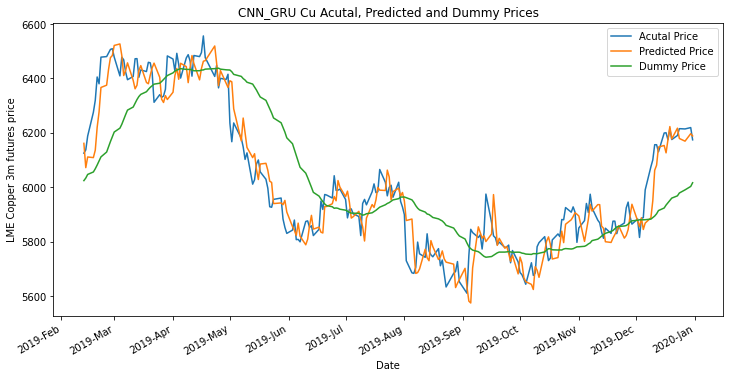

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

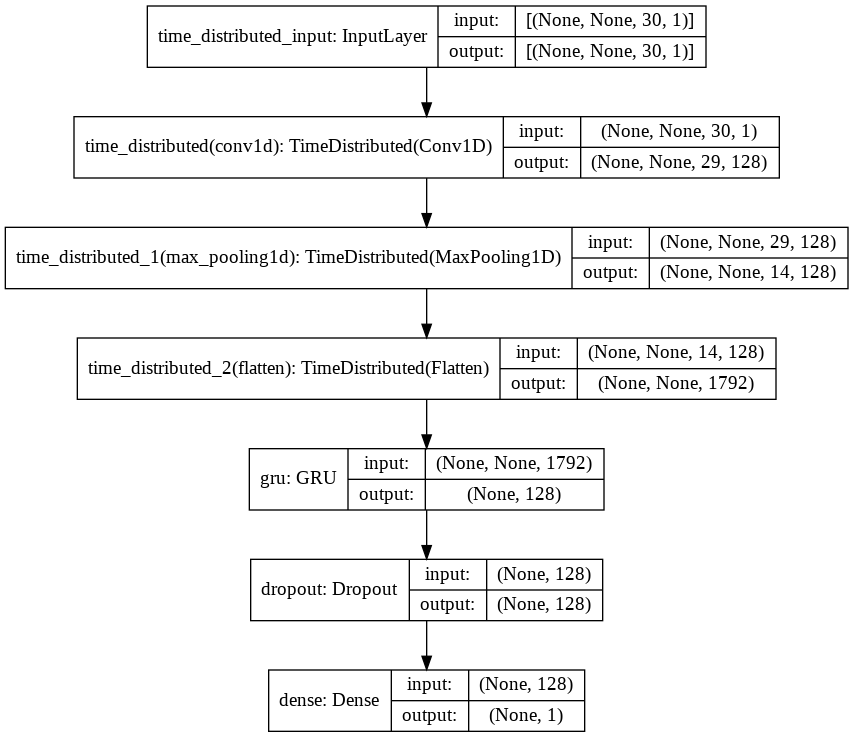

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0061044512582660625
RMSE:  0.07813098782343701
MAE:  0.06075943883430115
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Cu/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Cu/assets
